In [1]:
import pandas as pd
from casting.configuration import paths, columns
from casting.preprocessing import calculate_defect_rate, drop_null, remove_extreme_outliers, split_by_dbscan
from casting.utils import load_data

from casting.model.ml_model import train_xgboost, train_lightgbm, train_extra_trees

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

/var/folders/kc/2d8dbwd13vv1nn8nl99cb98r0000gn/T/ipykernel_62235/2839186551.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')


# preprocessing

### 1. base

In [3]:
## null 값 제외
data = drop_null(data)

# ## 극단값 제외
# for col in columns.numeric_columns :
#     data = remove_extreme_outliers(data, col)

data.reset_index(drop=True, inplace = True)

### 2. data split

In [4]:
split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [5]:
X_train, y_train, X_valid, y_valid = load_data('ml')

test = pd.read_csv(paths.ml_test_path)
X_test, y_test = test[columns.input_columns], test[columns.target_column]

### ML Modeling

In [6]:
model = train_extra_trees(X_train, X_valid, y_train, y_valid)

/Users/yuyeongchan/opt/anaconda3/envs/saas-control-job/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


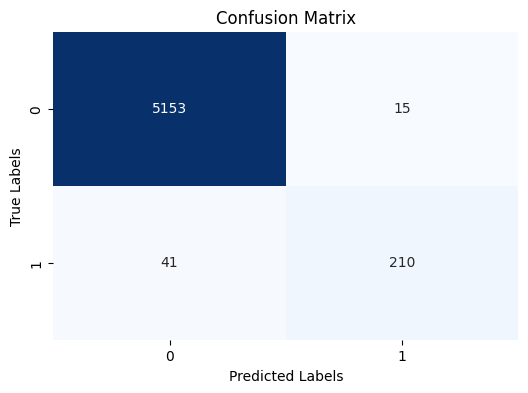

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

y_pred = model.predict(X_test)
test_cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')

F1 Score: 0.8824
accuracy_score: 0.9897
precision_score: 0.9333
recall_score: 0.8367


## FTT Modeling